# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from scipy.io import arff

from algo_implementation import logistic_regression
from preprocessor import Preprocessor

# library & dataset
import seaborn as sns
import matplotlib.pyplot as plt


# Dataset 2 preparation

## Preprocessing

In [3]:
# read data from csv file
data2 = pd.read_csv('Tetuan_city_power_cons.csv')

In [4]:
data2 = data2[:10000]

In [5]:
# set index to datetime with localized timezone
data2 = data2.set_index('DateTime')
data2.index = pd.to_datetime(data2.index).tz_localize('UTC')

In [6]:
data2.columns = data2.columns.str.replace(' ', '_')

In [7]:
# no data leaks
data2.isna().sum()

Temperature                  0
Humidity                     0
Wind_Speed                   0
general_diffuse_flows        0
diffuse_flows                0
Zone_1_Power_Consumption     0
Zone_2__Power_Consumption    0
Zone_3__Power_Consumption    0
dtype: int64

Text(0.5, 1.0, 'Geometric interpretation of standard consumption')

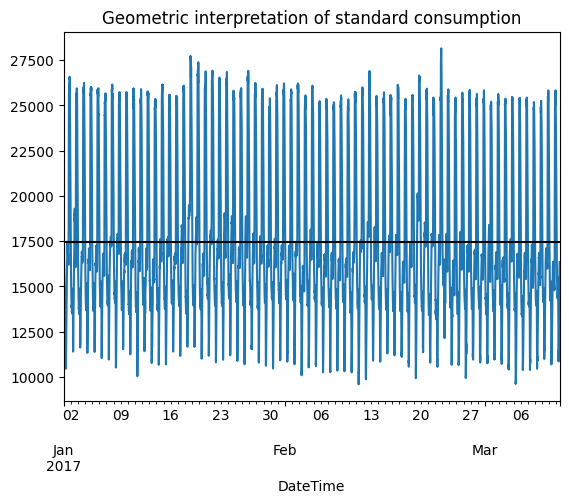

In [8]:
data2['Zone_3__Power_Consumption'].plot()
calculated_mean = data2['Zone_3__Power_Consumption'].mean()
plt.axhline(y=calculated_mean, color='black', linestyle='-')
plt.title('Geometric interpretation of standard consumption')

In [9]:
data2['class'] = np.where(data2['Zone_3__Power_Consumption'] > calculated_mean, 1, 0)

# Feature slection

In [14]:
from power_qcut import qcut_fold_validation, prepare_cols_comb

In [12]:
basic_cols = ['Temperature', 'Humidity', 'Wind_Speed', 'general_diffuse_flows',
       'diffuse_flows', 'Zone_1_Power_Consumption',
       'Zone_2__Power_Consumption', 'Zone_3__Power_Consumption']

In [18]:
cols1 = prepare_cols_comb(prepare_cols_comb(basic_cols))

In [23]:
results = qcut_fold_validation(data2, 3, 'class', cols1, np.mean, 7, condition = 'abs(mono) > 0.95')

100%|██████████| 13027/13027 [00:11<00:00, 1143.80it/s]


In [37]:
cols_to_check = results[(results.mono.isin([-1,1])) & (abs(results.slope)>0.18)].feature.reset_index(drop=True)

In [38]:
cols_to_check

0     Temperature / Zone_3__Power_Consumption / Zone...
1     Wind_Speed - Zone_1_Power_Consumption / Zone_2...
2     Zone_1_Power_Consumption / Zone_3__Power_Consu...
3     general_diffuse_flows - Zone_1_Power_Consumpti...
4     Wind_Speed - Zone_3__Power_Consumption * Zone_...
5     Temperature / Zone_3__Power_Consumption / Zone...
6     Temperature - Zone_1_Power_Consumption / Zone_...
7     Humidity - Zone_3__Power_Consumption * Zone_1_...
8     Wind_Speed - Zone_1_Power_Consumption * Zone_3...
9     diffuse_flows - Zone_1_Power_Consumption / Zon...
10    Temperature - Zone_1_Power_Consumption * Zone_...
11    Zone_2__Power_Consumption / Zone_1_Power_Consu...
12    Humidity - Zone_1_Power_Consumption * Zone_3__...
13    Temperature - Zone_3__Power_Consumption * Zone...
14    Temperature * general_diffuse_flows - Zone_1_P...
15    Humidity - Zone_1_Power_Consumption / Zone_2__...
16    Zone_1_Power_Consumption / Zone_3__Power_Consu...
17    Zone_2__Power_Consumption / Zone_3__Power_

In [39]:
data2.groupby([
    pd.qcut(data2.eval(cols_to_check[0]), 7),
]).agg(['mean', 'count','sum'])[['class']]

class            
                                    mean count   sum
(-0.000999999999552, 9.16e-13]  1.000000  1429  1429
(9.16e-13, 1.79e-12]            0.869048  1428  1241
(1.79e-12, 2.44e-12]            0.350595  1429   501
(2.44e-12, 2.93e-12]            0.073529  1428   105
(2.93e-12, 3.53e-12]            0.041987  1429    60
(3.53e-12, 4.65e-12]            0.000700  1428     1
(4.65e-12, 1.24e-11]            0.000000  1429     0

In [44]:
data2['qcut_var'] = data2.eval(cols_to_check[0])

## Split

In [47]:
X = data2.drop(['class','Zone_3__Power_Consumption'], axis=1)
y = data2['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size = 0.2)

## Correlation

In [48]:
X_train.corr()

,Temperature,Humidity,Wind_Speed,general_diffuse_flows,diffuse_flows,Zone_1_Power_Consumption,Zone_2__Power_Consumption,qcut_var
Temperature,1.000000,-0.479116,0.106329,0.459403,0.320477,0.345009,0.323927,0.090690
Humidity,-0.479116,1.000000,-0.054192,-0.454328,-0.385985,-0.262715,-0.222085,0.055591
Wind_Speed,0.106329,-0.054192,1.000000,0.024173,0.018607,-0.017771,-0.057719,0.109288
general_diffuse_flows,0.459403,-0.454328,0.024173,1.000000,0.725660,0.178975,0.181707,-0.014929
diffuse_flows,0.320477,-0.385985,0.018607,0.725660,1.000000,0.170101,0.162800,-0.039197
Zone_1_Power_Consumption,0.345009,-0.262715,-0.017771,0.178975,0.170101,1.000000,0.952927,-0.749134
Zone_2__Power_Consumption,0.323927,-0.222085,-0.057719,0.181707,0.162800,0.952927,1.000000,-0.773882
qcut_var,0.090690,0.055591,0.109288,-0.014929,-0.039197,-0.749134,-0.773882,1.000000


<AxesSubplot: >

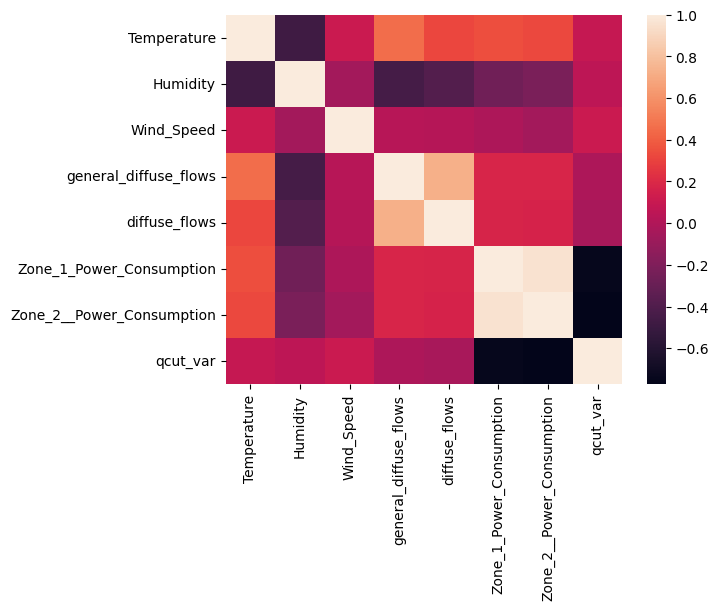

In [49]:
sns.heatmap(X_train.corr())

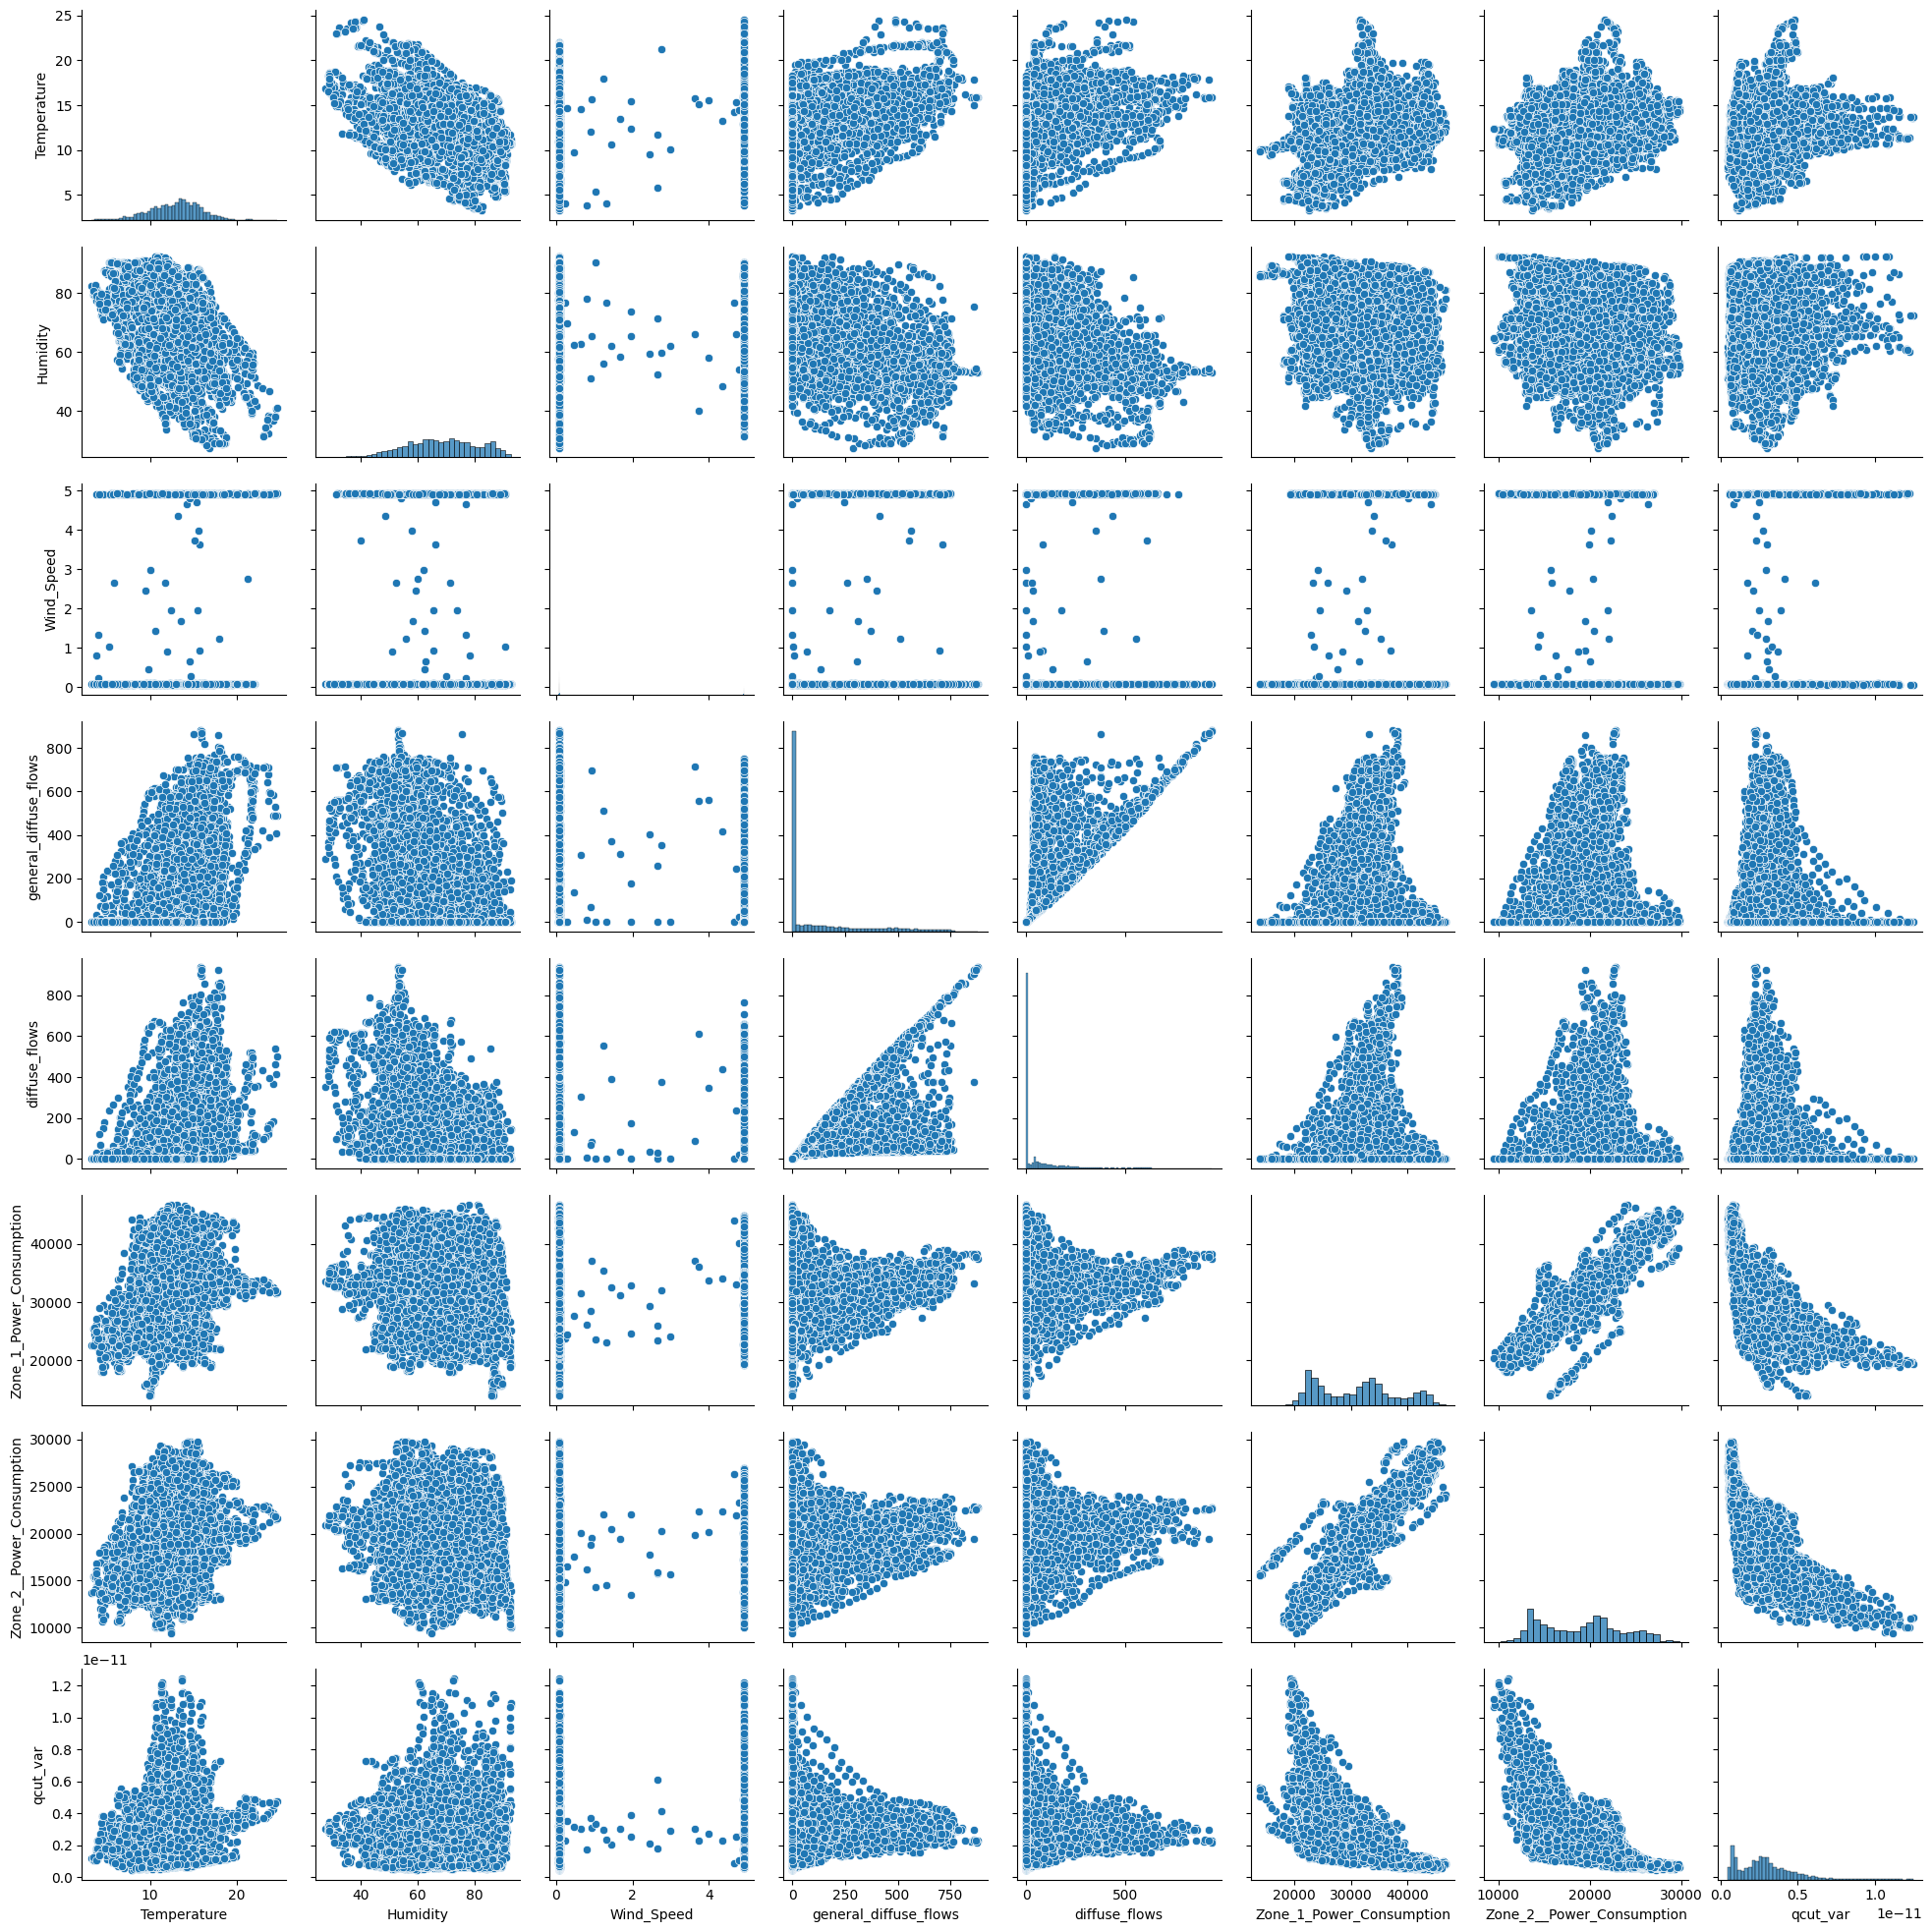

In [50]:
# Basic correlogram
sns.pairplot(X_train)


In [52]:
p = Preprocessor()
vif_coefs = p.vif(X_train)
vif_coefs[vif_coefs['VIF'] >= 0]

,variables,VIF
0,Temperature,20.609703
1,Humidity,12.726990
2,Wind_Speed,1.320280
3,general_diffuse_flows,3.426642
4,diffuse_flows,2.749617
5,Zone_1_Power_Consumption,222.854267
6,Zone_2__Power_Consumption,215.080527
7,qcut_var,9.709183


In [61]:
# standarize data
X_train_stded = (X_train - X_train.mean()) / X_train.std()
# standariz test data with train data mean and std
X_test_stded = (X_test - X_train.mean()) / X_train.std()

In [59]:
X_train_stded = X_train_stded.drop(['Zone_2__Power_Consumption'], axis=1)
vif_coefs = p.vif(X_train_stded)
vif_coefs[vif_coefs['VIF'] >= 4]

,variables,VIF


## Fit IRLS model

In [63]:
model = logistic_regression()
model.fit(X_train_stded, y_train)
print('beta:', model.beta)
accuracy = model.accuracy(X_test_stded, y_test)
print('Accuracy: {:.2f}'.format(accuracy))

beta: [-23.04641679  18.62383898   0.20197992  -0.46493725  -0.85802544
   0.22801377   3.21508295 -19.50521508 -62.07567454]
Accuracy: 0.99


## Export data to csv

In [66]:
pd.concat([X_train_stded, y_train], axis=1).to_csv('train_dataset2.csv')
pd.concat([X_test_stded, y_test], axis=1).to_csv('test_dataset2.csv')